# Plot Stellar Deconvolution

Series of scripts to create nice plots to shows the result of the deconvolution with stan

### data format

stan data is exported as csv. Each parameter have is own column (a.1, a.2, etc). Simulated flux are marked in columns also (flux_sim.1, flux_sim.2, ..., flux_sim.161). The same for flux_sim_conv and flux_sim_rng.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### NicePlot

The plot_axs function do the plot in each axs, receive the path to the csv, load it and get the data required.

Each plot have:
- the true profile
- the median profile obtained via median of parameters a,b and c
- a sample of models

In [71]:
# modification of NicePlot previously wrote so now it will include:
# * For each model will include both true, convoluted and rng profile

class NicePlot:
    
    def __init__(self, true_profile_path, input_list, line=6562.8, size_samples=1000):
        
        # load the true profile which will be common for all models
        x, y = np.loadtxt(true_profile_path, usecols=(2,4), unpack=True)
        self.true_wave = np.linspace(x[0], x[-1], len(x)) - line
        self.true_flux = np.interp(self.true_wave+line, x, y) - 1
        
        # set number of samples to draw
        self.size_samples = size_samples
        
        # load the data
        self.input_dict = self.load_data(input_list)
        
        # do the plot
        self.do_the_plot()
        
        self.show_plot()
        
    def load_data(self, input_list):
        
        input_dict = {}
        
        for model in input_list:
            model_split = model.split('_')
            number_gauss = int(model_split[1][0])
            vsini = float(model_split[3])
            noise = float(model_split[5])
            input_file = '../rstan/finished_models/dats/'+model[0:7]+model[10:]+'.dat'
            csv_file = '../rstan/'+model+'_params.csv'
            
            input_dict[model] = (number_gauss, vsini, noise, input_file, csv_file)
            
        return input_dict
        
    def do_the_plot(self):
        
        # get the number of models
        n_models = len(self.input_dict)
        
        # create the figure
        # two columns: input plus stan models, and recovered profile
        self.fig, axs = plt.subplots(n_models, 3, figsize=(9.6, 8.4), dpi=80)
        
        i = 0
        hide_xaxis = False
        title = True
        for model in self.input_dict.keys():
            if i == n_models - 1:
                hide_xaxis = False
            if i > 0:
                title = False
            self.plot_axs(axs[i,0], axs[i,1], axs[i,2], self.input_dict[model], hide_xaxis=hide_xaxis,
                         title=title)
            i += 1
    
    def plot_axs(self, axs0, axs1, axs2, model_data, hide_xaxis, title):
        
        # load model data
        ngauss = model_data[0]
        vsini = model_data[1]
        noise = model_data[2]
        input_file = model_data[3]
        csv_file = model_data[4]
        
        # load files
        input_dat = np.loadtxt(input_file)
        csv_dat = pd.read_csv(csv_file)
        
        # box text props
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
        # axs0: 
        # plot input profile with noise
        # then rngstan solutions
        self.draw_samples(csv_dat, axs0, 'flux_sim_rng')
        axs0.plot(input_dat[:,0], input_dat[:,1], color='black', lw=2, ls='-')
        # text
        text = 'vsini={} km/s\nnoise={}'.format(vsini, noise)
        axs0.text(0.05, 0.7, text, transform=axs0.transAxes, fontsize=10, bbox=props)
        
        # axs1:
        # get median stan profile
        # plot true profile
        # then stan solutions
        # then median stan profile
        a_median, b_median, c_median = self.get_median_parameters(csv_dat, ngauss)
        median_profile = self.n_gauss(self.true_wave, a_median, b_median, c_median)

        self.draw_samples(csv_dat, axs1, 'flux_sim')
        axs1.plot(self.true_wave, self.true_flux, color='black', lw=2, ls='-')
        axs1.plot(self.true_wave, median_profile, color='green', lw=3, ls='-')
        
        text = 'n_gaussians={}'.format(ngauss)
        axs1.text(0.05, 0.8, text, transform=axs1.transAxes, fontsize=10, bbox=props)
        
        # axs2:
        # residuals median profile - true profile
        self.draw_samples_res(csv_dat, axs2)
        axs2.plot(self.true_wave, self.true_flux-median_profile, color='black', lw=2, ls='-')
        
        # set ylims
        axs0.set_ylim([-0.25, 0.5])
        axs1.set_ylim([-0.25, 0.5])
        
        # hide x axis
        if hide_xaxis:
            axs0.get_xaxis().set_ticks([])        
            axs1.get_xaxis().set_ticks([])
            axs2.get_xaxis().set_ticks([])
            
        # remove axs1 yaxis
        axs1.get_yaxis().set_ticks([])
        
        # move axs2 yaxis to right
        axs2.yaxis.tick_right()
        
        # add titles
        if title:
            axs0.set_title('Input')
            axs1.set_title('Recovered')
            axs2.set_title('Residuals')

        
    def draw_samples(self, model, axs, which_one):
        # which_one : flux_sim_rng, flux_sim
        
        # read the model and select a random sample
        # get the dimensions of model, then draw random ints
        lenmodel = len(model)
        rng = np.random.default_rng()
        samples = rng.integers(low=0, high=lenmodel, size=self.size_samples)
        
        # for each sample draw a model
        for sample in samples:
            y_sample = np.zeros(len(self.true_wave))
            for i in range(len(self.true_wave)):
                y_sample[i] = model['{}.{}'.format(which_one, i+1)].to_numpy()[sample]
            axs.plot(self.true_wave, y_sample, color='blue', lw=1, alpha=0.25)
        # repeat the last one with a label
        
    def draw_samples_res(self, model, axs):
        # modification of function above, draw the samples - true profile
        lenmodel = len(model)
        rng = np.random.default_rng()
        samples = rng.integers(low=0, high=lenmodel, size=self.size_samples)
        
        # for each sample draw a model
        for sample in samples:
            y_sample = np.zeros(len(self.true_wave))
            for i in range(len(self.true_wave)):
                y_sample[i] = model['flux_sim.{}'.format(i+1)].to_numpy()[sample]
            axs.plot(self.true_wave, self.true_flux-y_sample, color='blue', lw=1, alpha=0.25)
        # repeat the last one with a label
        
    def get_median_parameters(self, model, m):
        
        a_median = []
        b_median = []
        c_median = []
        
        for m_i in range(m):
            a_m = model['a.{}'.format(m_i+1)].to_numpy()
            a_median.append(np.median(a_m))
            b_m = model['b.{}'.format(m_i+1)].to_numpy()
            b_median.append(np.median(b_m))
            c_m = model['c.{}'.format(m_i+1)].to_numpy()
            c_median.append(np.median(c_m))
        
        a_median = np.array(a_median)
        b_median = np.array(b_median)
        c_median = np.array(c_median)
        return (a_median, b_median, c_median)
    
    def gauss(self, x, args):
        a,b,c = args
        return a * np.exp(-((x-b)/c)**2 / 2)

    def n_gauss(self, x, a, b, c):
        out = np.zeros(len(x))
        for m in range(len(a)):
            out += self.gauss(x, (a[m], b[m], c[m]))
        return out
    
    def show_plot(self):
        plt.subplots_adjust(hspace=0, wspace=0.025)
        plt.text(0.5, 0.05, r'$\Delta$ Wavelength [$\rm\AA$]', fontsize=18, transform=self.fig.transFigure,
                 ha='center')
        plt.text(0.05, 0.5, 'Normalized Flux - 1', fontsize=18, transform=self.fig.transFigure, va='center',
                 rotation='vertical')
        plt.savefig('test.pdf', format='pdf')
        plt.show()

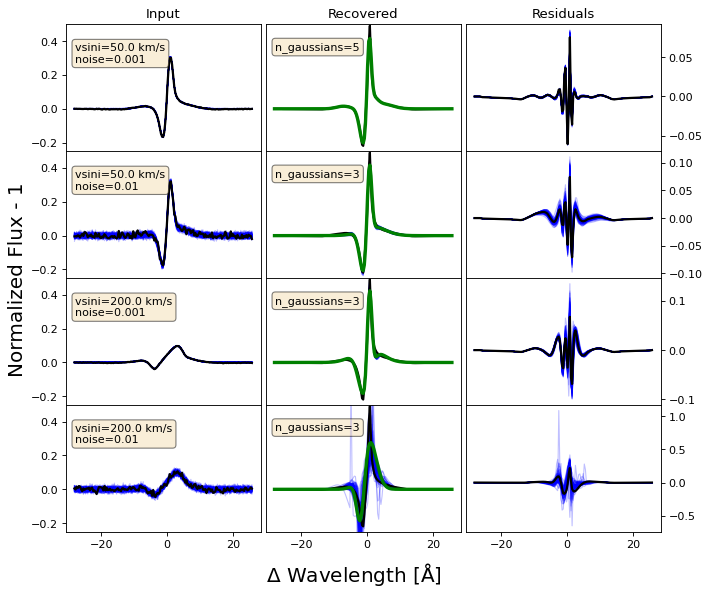

In [72]:
true_profile_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/profiles/OUT.HALPHA_VT010-Pcygni'
model1 = 'pcygni_5g_vsini_50_noise_1e-3'
model2 = 'pcygni_3g_vsini_50_noise_1e-2'
model3 = 'pcygni_3g_vsini_200_noise_1e-3'
model4 = 'pcygni_3g_vsini_200_noise_1e-2'
input_list = [model1, model2, model3, model4]

niceplot = NicePlot(true_profile_path, input_list, size_samples=100)

In [14]:
a = 'pcygni_5g_vsini_50_noise_1e-3'
print(a[0:7]+a[10:])

pcygni_vsini_50_noise_1e-3


In [69]:
class NicePlot:

    def __init__(self, true_profile_path, line=6562.8, size_samples=1000, figsize_y=7.4):
        
        # load the true profile which will be common for all models
        x, y = np.loadtxt(true_profile_path, usecols=(2,4), unpack=True)
        self.true_wave = np.linspace(x[0], x[-1], len(x)) - line
        self.true_flux = np.interp(self.true_wave+line, x, y) - 1
        
        # set number of samples to draw
        self.size_samples = size_samples
        
        # create the figure
        self.fig, self.axs = plt.subplots(2, 2, figsize=(1.62*figsize_y, figsize_y), dpi=80)
    
    def plot_axs(self, axs, model_path, m, text, hide_xaxis=False, hide_yaxis=False):
    
        # load the respective csv and get the data desired
        model = pd.read_csv(model_path)
    
        # draw samples first, so they go to the bottom
        self.draw_samples(model, axs)
    
        # do the plot for each axs
        # start with the true profile
        axs.plot(self.true_wave, self.true_flux, color='black', lw=3, label='True')
        
        # get the median parameters
        # compute the gaussian profile
        # and plot it
        a_median, b_median, c_median = self.get_median_parameters(model, m)
        median_profile = self.n_gauss(self.true_wave, a_median, b_median, c_median)
        axs.plot(self.true_wave, median_profile, color='green', lw=3, label='Median')
        
        # set ylims
        axs.set_ylim([-0.4, 0.6])
        
        # legend
        axs.legend(loc=0, fontsize=14)
        
        # text
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs.text(0.65, 0.05, text, transform=axs.transAxes, fontsize=12, bbox=props)
        
        # tick label sizes
        axs.tick_params(axis='both', labelsize=15)
        
        # hide axes if parameters are true
        if hide_xaxis:
            axs.get_xaxis().set_ticks([])
        if hide_yaxis:
            axs.get_yaxis().set_ticks([])
    
    def get_median_parameters(self, model, m):
        
        a_median = []
        b_median = []
        c_median = []
        
        for m in range(m):
            a_m = model['a.{}'.format(m+1)].to_numpy()
            a_median.append(np.median(a_m))
            b_m = model['b.{}'.format(m+1)].to_numpy()
            b_median.append(np.median(b_m))
            c_m = model['c.{}'.format(m+1)].to_numpy()
            c_median.append(np.median(c_m))
        
        a_median = np.array(a_median)
        b_median = np.array(b_median)
        c_median = np.array(c_median)
        return (a_median, b_median, c_median)
    
    def gauss(self, x, args):
        a,b,c = args
        return a * np.exp(-((x-b)/c)**2 / 2)

    def n_gauss(self, x, a, b, c):
        out = np.zeros(len(x))
        for m in range(len(a)):
            out += self.gauss(x, (a[m], b[m], c[m]))
        return out
    
    def draw_samples(self, model, axs):
        # read the model and select a random sample
        # get the dimensions of model, then draw random ints
        lenmodel = len(model)
        rng = np.random.default_rng()
        samples = rng.integers(low=0, high=lenmodel, size=self.size_samples)
        
        # for each sample draw a model
        for sample in samples:
            y_sample = np.zeros(len(self.true_wave))
            for i in range(len(self.true_wave)):
                y_sample[i] = model['flux_sim.{}'.format(i+1)].to_numpy()[sample]
            axs.plot(self.true_wave, y_sample, color='blue', lw=1, alpha=0.25)
        # repeat the last one with a label
        axs.plot(self.true_wave, y_sample, color='blue', lw=1, alpha=0.25, label='Sample')
    
    def show(self, savename=None):
        plt.subplots_adjust(wspace=0.06, hspace=0.1)
        plt.text(0.5, 0.05, r'$\Delta$ Wavelength [$\rm\AA$]', fontsize=18, transform=self.fig.transFigure,
                 ha='center')
        plt.text(0.05, 0.5, 'Normalized Flux - 1', fontsize=18, transform=self.fig.transFigure, va='center',
                 rotation='vertical')
        if savename is not None:
            plt.savefig(savename, format='pdf')
        plt.show()

KeyboardInterrupt: 

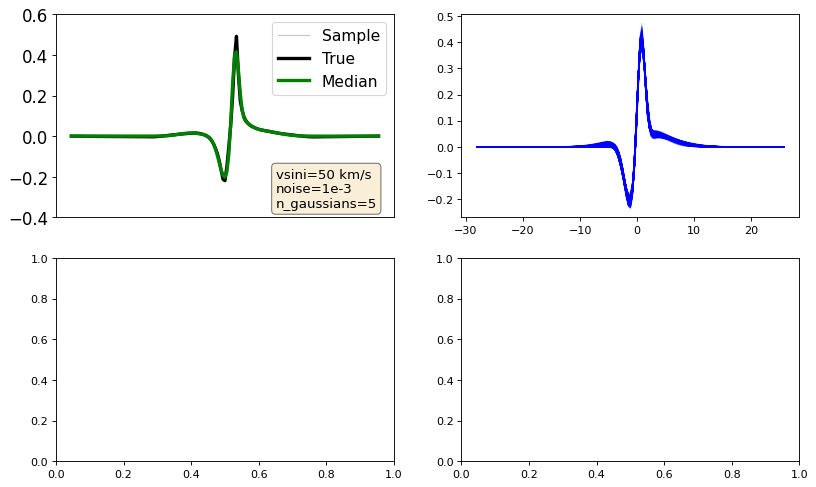

In [70]:
# true profile path
true_profile_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/profiles/OUT.HALPHA_VT010-Pcygni'
model1_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/rstan/pcygni_5g_vsini_50_noise_1e-3_params.csv'
model2_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/rstan/pcygni_3g_vsini_50_noise_1e-2_params.csv'
model3_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/rstan/pcygni_3g_vsini_200_noise_1e-3_params.csv'
model4_path = '/home/lientur/DoctoradoUV/Investigation/deconvolution/rstan/pcygni_3g_vsini_200_noise_1e-2_params.csv'

niceplot = NicePlot(true_profile_path)
niceplot.plot_axs(niceplot.axs[0,0], model1_path, 5, text='vsini=50 km/s\nnoise=1e-3\nn_gaussians=5', 
                  hide_xaxis=True)
niceplot.plot_axs(niceplot.axs[0,1], model2_path, 3, text='vsini=50 km/s\nnoise=1e-2\nn_gaussians=3', 
                  hide_xaxis=True, hide_yaxis=True)
niceplot.plot_axs(niceplot.axs[1,0], model3_path, 3, text='vsini=200 km/s\nnoise=1e-3\nn_gaussians=3')
niceplot.plot_axs(niceplot.axs[1,1], model4_path, 3, text='vsini=200 km/s\nnoise=1e-2\nn_gaussians=3', 
                  hide_yaxis=True)
niceplot.show(savename='pcygni_recovering_true.pdf')

### Execution time vs vsini vs noise vs number of gaussians

This part is to show how the execution time depends on these different parameters. Load the deconvolution_data.csv file to read the data.

Plot the execution time (yaxis) vs vsini(x-axis). Make distinction between gaussian number (by shape ?). Also, do two plots, one for absorption and another for pcygni profile.

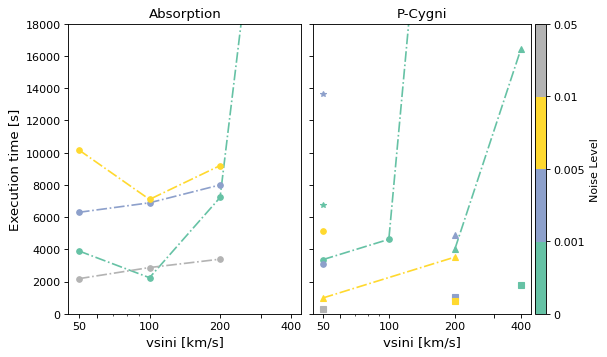

In [53]:
# load color maps
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# load the data from the csv file
deconvolution_data_path = '../deconvolution_data.csv'
deconvolution_data = pd.read_csv(deconvolution_data_path)

# load the data from the columns
ex_time = deconvolution_data['execution time'].to_numpy()
vsini = deconvolution_data['vsini'].to_numpy()
noise = deconvolution_data['noise'].to_numpy()
ngauss = deconvolution_data['gaussian number'].to_numpy()
profile = deconvolution_data['profile']

noise_val = [1e-3, 5e-3, 1e-2, 5e-2]
ngauss_ = [2,3,4,5]
markers = ['s','^','o','*']

# create the figure
fig, axs = plt.subplots(1, 2, figsize=(7.7, 4.8), dpi=80, sharey=True)

# colors from cmap
colors = cm.Set2(np.linspace(0, 1, 4))

# plot execution time vs vsini
# absorption
for i in range(4):
    sel1 = (profile=='absorption') & (noise==noise_val[i])
    sel2 = (profile=='pcygni') & (noise==noise_val[i])
    
    axs[0].plot(vsini[sel1], ex_time[sel1], color=colors[i], ls='-.', marker='o', ms=5)
    for j in range(4):
        sel3 = sel2 & (ngauss==ngauss_[j])
        axs[1].plot(vsini[sel3], ex_time[sel3], color=colors[i], ls='-.', marker=markers[j], ms=5)

axs[1].set_ylim([0,18000])

axs[0].set_xlabel('vsini [km/s]', fontsize=12)
axs[1].set_xlabel('vsini [km/s]', fontsize=12)
axs[0].set_ylabel('Execution time [s]', fontsize=12)

axs[0].set_title('Absorption')
axs[1].set_title('P-Cygni')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_xticks([50,60,100,200,300,400])
axs[0].set_xticklabels(('50','','100','200','','400'))

axs[1].set_xticks([50,60,100,200,300,400])
axs[1].set_xticklabels(('50','','100','200','','400'))

# color bar
divider = make_axes_locatable(axs[1])
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)

cmap = mpl.cm.Set2
bounds = np.arange(5)
norm = mpl.colors.BoundaryNorm(bounds, 9)
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax_cb, orientation='vertical',
                  label='Noise Level')
cbar.ax.set_yticklabels([0,1e-3,5e-3,1e-2,5e-2])

plt.subplots_adjust(wspace=0.05)

plt.savefig('execution_time.pdf', format='pdf')
plt.show()

## squared difference and EW difference versus noise

This part plots the squared difference and EW versus the vsini and noise for both profiles.

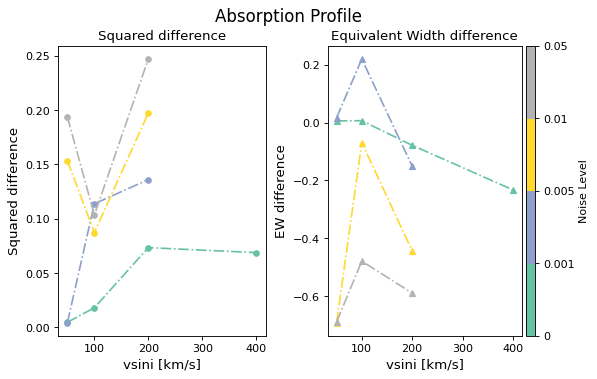

In [54]:
# load the data from the csv file
deconvolution_data_path = '../deconvolution_data.csv'
deconvolution_data = pd.read_csv(deconvolution_data_path)

# load the data from the columns
vsini = deconvolution_data['vsini'].to_numpy()
noise = deconvolution_data['noise'].to_numpy()
ngauss = deconvolution_data['gaussian number'].to_numpy()
profile = deconvolution_data['profile']
sqr_dif = deconvolution_data['sqr_sum_dif'].to_numpy()
ew_dif = deconvolution_data['ew_dif'].to_numpy()

# do the plot
# for the momento only absorption profile is done
sel_profile = (profile == 'absorption')

fig, axs = plt.subplots(1, 2, figsize=(7.7,4.8), dpi=80)

colors = cm.Set2(np.linspace(0, 1, 4))
noise_val = [1e-3, 5e-3, 1e-2, 5e-2]

for i in range(4):
    sel_noise = (noise==noise_val[i])
    axs[0].plot(vsini[sel_profile&sel_noise], sqr_dif[sel_profile&sel_noise], color=colors[i],
                ls='-.', marker='o', ms=5)

for i in range(4):
    sel_noise = (noise==noise_val[i])
    axs[1].plot(vsini[sel_profile&sel_noise], ew_dif[sel_profile&sel_noise], color=colors[i],
                ls='-.', marker='^', ms=5)

axs[0].set_title('Squared difference')
axs[1].set_title('Equivalent Width difference')

axs[0].set_xlabel('vsini [km/s]', fontsize=12)
axs[1].set_xlabel('vsini [km/s]', fontsize=12)
axs[0].set_ylabel('Squared difference', fontsize=12)
axs[1].set_ylabel('EW difference', fontsize=12)

divider = make_axes_locatable(axs[1])
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)

cmap = mpl.cm.Set2
bounds = np.arange(5)
norm = mpl.colors.BoundaryNorm(bounds, 9)
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax_cb, orientation='vertical',
                  label='Noise Level')
cbar.ax.set_yticklabels([0,1e-3,5e-3,1e-2,5e-2])

fig.suptitle('Absorption Profile', fontsize=15)
plt.subplots_adjust(wspace=0.30)

plt.savefig('Squared_EW_difference.pdf', format='pdf')
plt.show()